In [12]:
# **Customer Churn Analysis: A Machine Learning Approach to Classification Models**

In this project,we aim to find the likelihood of a customer leaving an organization, the key indicators of churn, as well as the retention strategies that can be implemented to avert this problem.

**Null Hypotheses**
-There is no difference in monthly charges(median) between customers who churn and those who do not churn.
- Customer churn depends on the period of time a customer has been with the company.

**Alternate Hypotheses**
-There is a difference in monthly cahrges(median) between customers who churn and those who do not churn.
- Customer churn does not depend on the period of time the customer has been with the company.


**Analytical Questions**
1. What is the churn rate among customers?
2.Does the type of internet service influence customer churn?
3. Does the method of billing affect the likelihood of churn?
4.How do support services(tech support and online security) influence customer satisfaction and retention?
5.Does churn vary significantly across gender and age groups?


**Import all necessary packages**

In [2]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu,chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, make_scorer, roc_auc_score, roc_curve

warnings. filterwarnings('ignore')

# **Data Collection**

**Load First Dataset From Database**

In [3]:
#Load environment variables from .env file
environment_variables = dotenv_values('.env')

#Get all credentials in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string = f"DRIVER={{SQL Server}}; \
                    SERVER={server}; \
                    DATABASE={database}; \
                    UID={username}; \
                    PWD={password};"

# Connect to the server
connection = pyodbc.connect(connection_string)

In [4]:
#Load first dataset with 3000 records
first_data = pd.read_sql_query(
    "SELECT * FROM dbo.LP2_Telco_churn_first_3000", connection)

# Saving the DataFrame to a CSV file
first_data.to_csv('Data/LP2_Telco_churn_first_3000.csv', index=False)

first_data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


**Load Second Dataset From CSV Files**

In [6]:
#Load second dataset with 2000 records
second_data = pd.read_csv('Data/LP2_Telco-churn-second-2000.csv')

# Data preview
second_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [7]:
test_data = pd.read_excel('Data/Telco-churn-last-2000.xlsx')
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


# **Data Information**

In [8]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [10]:
second_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


# **Data Cleaning**

In [12]:
first_data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [13]:
# Imputing with the mode 
categorical_columns = first_data.select_dtypes(
    include=['object', 'bool']).columns
for column in categorical_columns:
    if first_data[column].isnull().any():   
        mode_value = first_data[column].mode()[0]
        first_data[column].fillna(mode_value, inplace=True)

In [14]:
first_data['SeniorCitizen'] = first_data['SeniorCitizen'].apply(lambda x: 1 if x else 0)

bool_columns = ['Partner', 'Dependents', 'Churn', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                'PaperlessBilling']
for col in bool_columns:
    first_data[col] = first_data[col].map({True: 'Yes', False: 'No'}).fillna('No')

train_data = pd.concat([first_data, second_data], ignore_index=True)

In [15]:
train_data['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'], errors='coerce')
test_data['TotalCharges'] = pd.to_numeric(test_data['TotalCharges'], errors='coerce')

mean_total_charges = train_data['TotalCharges'].mean()
train_data['TotalCharges'].fillna(mean_total_charges, inplace=True)
test_data['TotalCharges'].fillna(mean_total_charges, inplace=True)

In [16]:
train_data.to_csv('data/train_data.csv', index=False)
test_data.to_csv('data/test_data.csv', index=False)

# **Exploratory Data Analysis(EDA)**

In [17]:
train_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,5043,5043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,5043,2,Male,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,5043.0,NaN,NaN,NaN,0.162403,0.368857,0.0,0.0,0.0,0.0,1.0
Partner,5043,2,No,2585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,5043,2,No,3482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,5043.0,NaN,NaN,NaN,32.576641,24.529807,0.0,9.0,29.0,56.0,72.0
PhoneService,5043,2,Yes,4554,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,5043,3,No,2693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,5043,3,Fiber optic,2248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,5043,3,No,3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 # ** Categorical Variables**
- **Gender**: Nearly evenly split between males and females, with males slightly more prevalent. This suggests that gender-specific targeting may not be necessary for churn prevention strategies.

- **Senior Citizen**: Only about `16.2%` of the customers are senior citizens, which could be a niche market to explore for specific services or retention strategies.

- **Partner and Dependents**: A slight majority do not have a partner `51%` or dependents `69%`. This could indicate that single, independent individuals may be a significant demographic, possibly with different needs or usage patterns.

- **Phone Service**: Almost `90% `of customers have phone service, indicating a saturation of this service and possibly lower churn risk here compared to other services.

- **Multiple Lines**: The majority do not have multiple lines `53%`, but there's a significant portion that does, suggesting varied needs in communication services.

- **Internet Service**: Fiber optic is the most common type of internet service `45%`, followed by DSL. The popularity of fiber optic could indicate a demand for high-speed internet but may also highlight issues like higher costs or service satisfaction affecting churn.

- **Online Security, Online Backup, Device Protection, Tech Support**: Most customers do not subscribe to these services. This could point to potential areas for increasing service uptake and reducing churn by bundling these value-added services.

- **Streaming TV and Streaming Movies**: Slightly more customers have streaming movies than TV. This might suggest a preference or trend towards movie streaming, which could be leveraged in service packages.

- **Contract**: More than half of the customers are on a month-to-month contract, associated with higher churn rates. This is a critical area to focus on for retention strategies, possibly by encouraging longer contract terms.

- **Paperless Billing**: About `59%` use paperless billing, indicating a significant shift towards digital solutions.

- **Payment Method**: The most common payment method is electronic check `34%`, which could be correlated with churn, suggesting a review of payment options might influence customer satisfaction and retention.


%`, which could be correlated with churn, suggesting a review of payment options might influence customer satisfaction and retention.

# ** Numerical Variables**

- **Tenure**: Ranges from `0` to `72` months, with an average of about `32.5` months. Longer tenure correlates strongly with lower churn, indicating the importance of focusing retention strategies on newer customers.

- **Monthly Charges**: Average monthly charges are about `$65.09`, but range widely from `$18.4` to `$118.65`, suggesting diverse service plans and possibly different price sensitivities among customers.

- **Total Charges**: Reflects the total amount spent by customers over time and varies widely, suggesting differing levels of customer engagement and investment in the services.


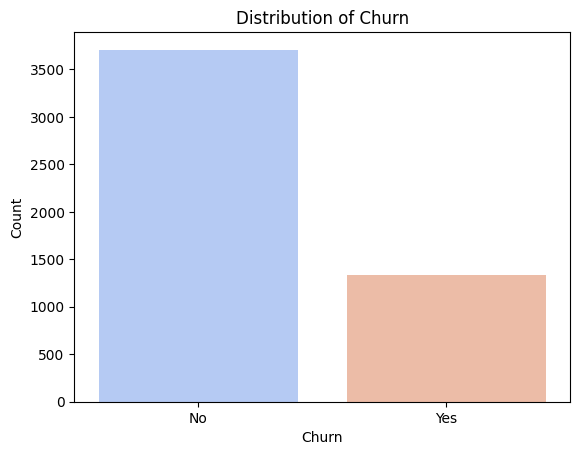

In [18]:
sns.countplot(x='Churn', data=train_data, palette='coolwarm')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Churn

- Majority of the dataset consists of customers who have not churned(74%),which is good but also highlights the importance of understanding why the 26% left.

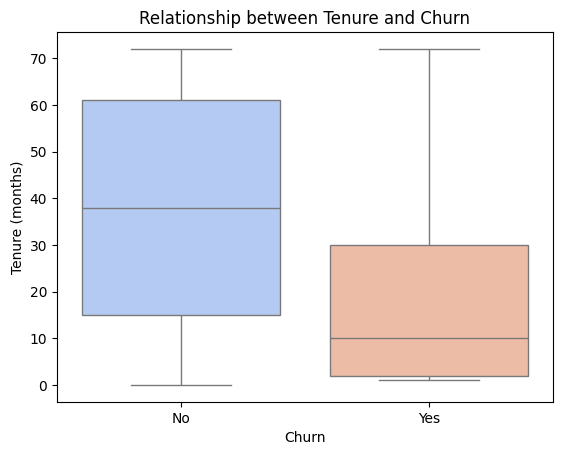

In [19]:
# Exploring the relationship between 'tenure' and 'Churn'

sns.boxplot(x='Churn', y='tenure', data=train_data, palette='coolwarm')
plt.title('Relationship between Tenure and Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')
plt.show()

- Customers who do not churn tend to have a higher tenure. This suggests that the longer a customer stays with the service, the less likely they are to churn.

- Customers who churn generally have a shorter tenure, indicating that churn is more frequent early in the customer relationship.

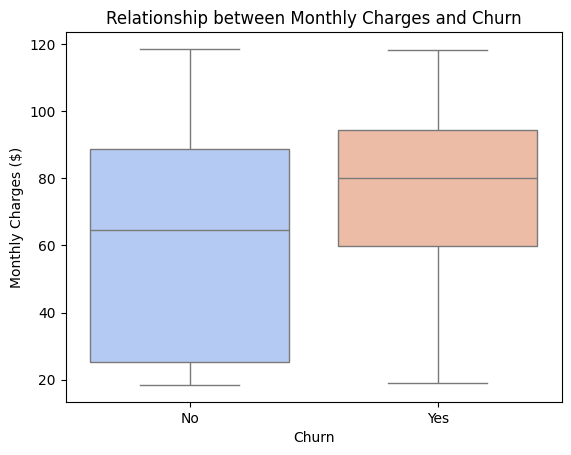

In [20]:
 #Exploring the relationship between 'MonthlyCharges' and 'Churn'

sns.boxplot(x='Churn', y='MonthlyCharges', data=train_data, palette='coolwarm')
plt.title('Relationship between Monthly Charges and Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges ($)')
plt.show()

- The monthly charges are generally higher for customers who churn. This might indicate that higher costs could be a factor in the decision to leave the service.

- Customers who do not churn tend to have a wider range of monthly charges but with a lower median, suggesting they might be on more economical plans.

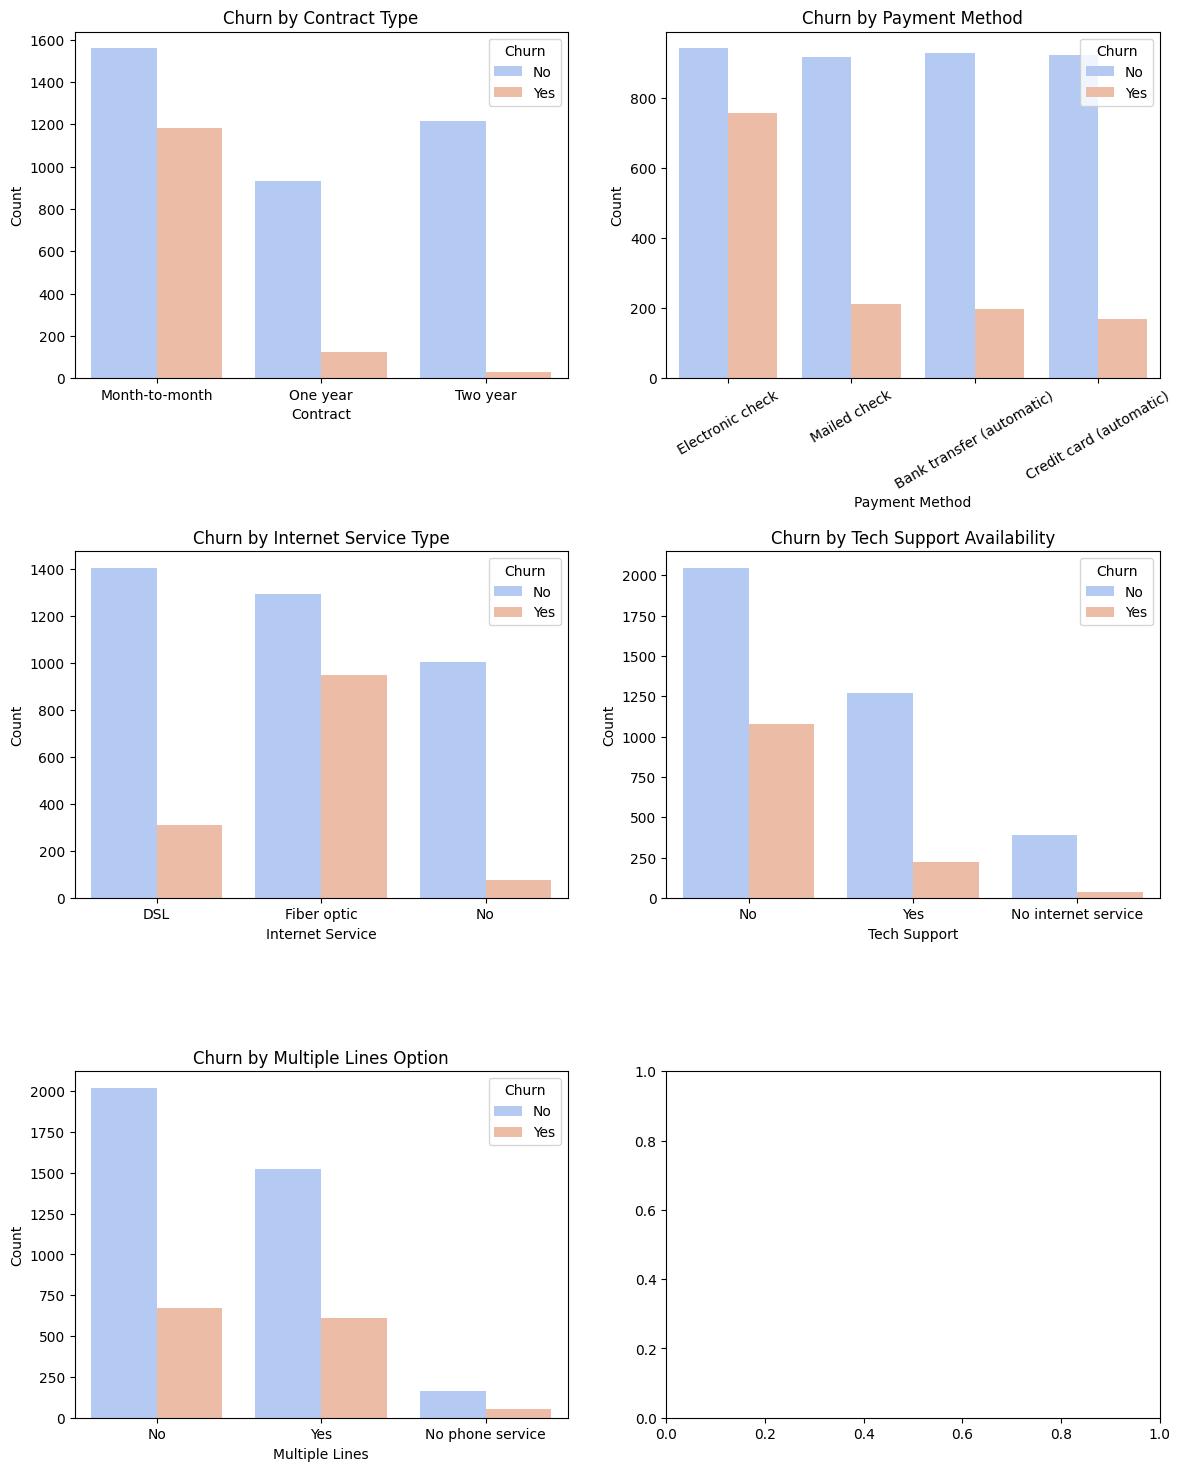

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
plt.subplots_adjust(hspace=0.5)

# Contract vs Churn
sns.countplot(ax=axes[0, 0], x='Contract', hue='Churn', data=train_data, palette='coolwarm')
axes[0, 0].set_title('Churn by Contract Type')
axes[0, 0].set_xlabel('Contract')
axes[0, 0].set_ylabel('Count')

# PaymentMethod vs Churn
sns.countplot(ax=axes[0, 1], x='PaymentMethod', hue='Churn', data=train_data, palette='coolwarm')
axes[0, 1].set_title('Churn by Payment Method')
axes[0, 1].set_xlabel('Payment Method')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=30)

# InternetService vs Churn
sns.countplot(ax=axes[1, 0], x='InternetService', hue='Churn', data=train_data, palette='coolwarm')
axes[1, 0].set_title('Churn by Internet Service Type')
axes[1, 0].set_xlabel('Internet Service')
axes[1, 0].set_ylabel('Count')

# TechSupport vs Churn
sns.countplot(ax=axes[1, 1], x='TechSupport', hue='Churn', data=train_data, palette='coolwarm')
axes[1, 1].set_title('Churn by Tech Support Availability')
axes[1, 1].set_xlabel('Tech Support')
axes[1, 1].set_ylabel('Count')

# MultipleLines vs Churn
sns.countplot(ax=axes[2, 0], x='MultipleLines', hue='Churn', data=train_data, palette='coolwarm')
axes[2, 0].set_title('Churn by Multiple Lines Option')
axes[2, 0].set_xlabel('Multiple Lines')
axes[2, 0].set_ylabel('Count')

plt.show()

**Churn by Contract Type**
- Customers with month-to-month contracts are more likely to churn compared to those with longer-term contracts. This suggests that customers on short-term commitments feel less bound and possibly less satisfied, leading to higher churn rates.  

**Churn by Payment Method**
- The method of payment also seems to influence churn, with electronic checks showing a higher churn rate. This might be due to the demographics or the convenience factors associated with this payment method.  

**Churn by Internet Service Type**
- Customers with fiber optic services show a higher churn rate compared to those with DSL. This might reflect issues like cost or service expectations not being met with the higher-speed option.  

**Churn by Tech Support Availability**
- Having tech support appears to be a significant factor in retention, as customers without tech support show higher churn rates. This suggests that better customer support could improve customer retention.  

**Churn by Multiple Lines Option**
- There isn't a stark difference in churn rates based on whether customers have multiple lines or not, suggesting that simply having multiple lines isn't a deciding factor for churn.  

**Churn by Streaming TV**
- Customers who subscribe to streaming TV services have slightly higher churn rates, particularly those without the service. This might suggest that value-added services like streaming could either be a retention tool or a point of dissatisfaction if not handled correctly.  